In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
from datetime import date

In [7]:
import plotly.offline as py
import plotly.graph_objs as go

In [8]:
py.init_notebook_mode(connected=True)
%matplotlib inline

In [9]:
data = pd.read_hdf('data_5m/binance.hdf', 'BTC/USDT').astype(np.float32)

In [10]:
data_c = data.set_index('timestamp')

In [11]:
data_c = data_c[~data_c.index.duplicated(keep='first')]

In [12]:
data_c.index = pd.DatetimeIndex(pd.to_datetime(data_c.index, unit='ms'), freq='infer')

In [13]:
data_c = data_c.resample('5min').mean()

In [14]:
data_c = data_c.interpolate()

In [15]:
data_c = data_c.reset_index()

In [16]:
data_c['date'] = data_c['timestamp'].dt.date

In [17]:
group = data_c.groupby('date')

In [18]:
Daily_Volume =  group['volume'].mean()

In [19]:
Daily_Volume.head()

date
2017-08-17    3.324117
2017-08-18    4.176270
2017-08-19    1.361048
2017-08-20    1.612014
2017-08-21    2.370942
Name: volume, dtype: float32

##### training and testing data as a dataframe

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
df1 = Daily_Volume.to_frame() 

In [22]:
working_data = df1
working_data = working_data.reset_index()
working_data.head()

,date,volume
0,2017-08-17,3.324117
1,2017-08-18,4.176270
2,2017-08-19,1.361048
3,2017-08-20,1.612014
4,2017-08-21,2.370942


#### 1. Reshaping the train and test set according to the requirements of the model.
#### 2. Scaling the dataset by using the MinMaxScaler because LSTM models are scale sensitive.

In [23]:
scaler = MinMaxScaler()

In [24]:
reshaped_working_data = np.reshape(working_data.volume.values, (len(working_data), 1))

In [25]:
scaled_reshaped_working_data = scaler.fit_transform(reshaped_working_data)

In [26]:
df_train, df_test = train_test_split(scaled_reshaped_working_data, test_size=0.20, shuffle=False)

In [27]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [28]:
look_back = 1
X_train, Y_train = create_lookback(df_train, look_back)
X_test, Y_test = create_lookback(df_test, look_back)

In [29]:
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [30]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False, 
                    validation_data=(X_test, Y_test), 
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 463 samples, validate on 115 samples
Epoch 1/100
463/463 [==============================] - 3s 6ms/step - loss: 0.0347 - val_loss: 0.0191
Epoch 2/100
463/463 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0147
Epoch 3/100
463/463 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0132
Epoch 4/100
463/463 [==============================] - 1s 3ms/step - loss: 0.0123 - val_loss: 0.0134
Epoch 5/100
463/463 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0132
Epoch 6/100
463/463 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0131
Epoch 7/100
463/463 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0131
Epoch 8/100
463/463 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0131
Epoch 9/100
463/463 [=====

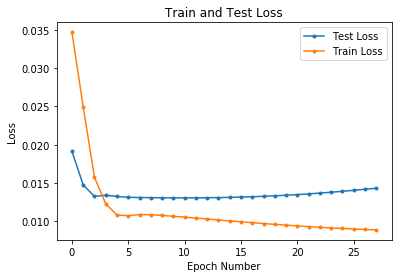

In [31]:
plt.plot(np.arange(0, len(history.history['val_loss']), 1), history.history['val_loss'], '.-',label='Test Loss')
plt.plot(np.arange(0, len(history.history['loss']), 1), history.history['loss'], '.-', label='Train Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch Number');

In [32]:
xt_mod = np.append(X_test, df_test[-1])

In [33]:
xt_mod = np.reshape(xt_mod, (len(xt_mod), 1, 1))

In [34]:
prediction = model.predict(xt_mod)

In [35]:
pred = scaler.inverse_transform(prediction.reshape(-1, 1))

In [36]:
pred = pred[:][1:]

In [37]:
y = scaler.inverse_transform(Y_test.reshape(-1, 1))[:]

In [38]:
RMSE = sqrt(mean_squared_error(y, pred))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 30.580


                Test RMSE: 30.580


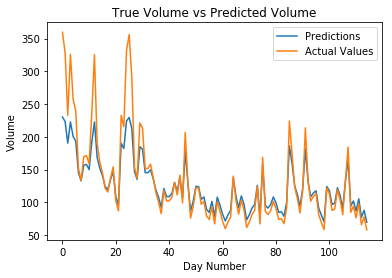

In [39]:
plt.plot(np.arange(0, len(pred), 1), pred, label = 'Predictions')
plt.plot(np.arange(0, len(y), 1), y, label = 'Actual Values')
plt.legend()
plt.xlabel('Day Number')
plt.ylabel('Volume')
plt.title('True Volume vs Predicted Volume')
RMSE = sqrt(mean_squared_error(y, pred))
print('                Test RMSE: %.3f' % RMSE)